/home/claudiusk/.conda/envs/depth-denoising_training/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /tmp/pip-req-build-1qm6302z/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


Means: Input 0.8828286528587341 Label 0.6041867733001709 Predicted 0.600391149520874


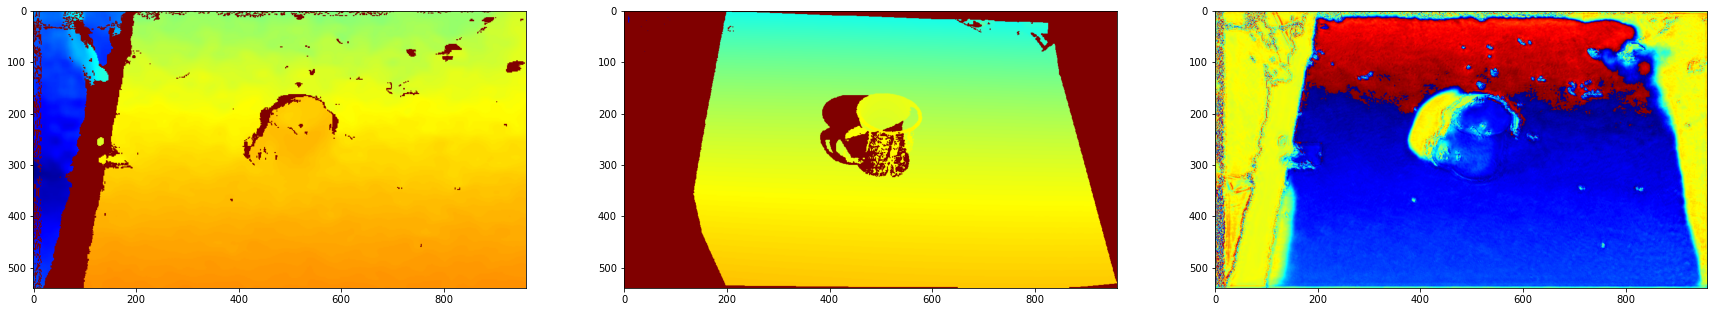

In [1]:
import argparse
import logging
from pathlib import Path
import numpy as np
import torch
from matplotlib import pyplot as plt
from dataset.data_loading import BasicDataset
from dataset.dataset_interface import DatasetInterface
from networks.UNet.unet_model import UNet
import cv2

from utils.visualization_utils import visualize_depth

resource_path = Path("../../resources")

class Args:
    model = resource_path / "M_11_e146.pth"
    input = resource_path / "images/calibrated/3d_aligned/dataset_2"
    scale = 0.5

def predict_img(net,
                files,
                device,
                scale_factor=1):
    net.eval()
    rs_rgb, rs_depth, _, zv_depth = files
    set = BasicDataset.preprocess_set(rs_rgb, rs_depth, zv_depth, scale_factor)
    img = set['image']
    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        pred_depths = net(img)
    
    pred_depths = pred_depths[0, 0].float().cpu().detach().numpy()
    return pred_depths 

args = Args()
dataset = DatasetInterface(Path(args.input))

net = UNet(n_input_channels=4, n_output_channels=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Loading model {args.model}')
logging.info(f'Using device {device}')

net.to(device=device)
net.load_state_dict(torch.load(args.model, map_location=device))

logging.info('Model loaded!')

idx = np.random.randint(len(dataset), size=1).item()
files = dataset[idx]

logging.info(f'\nPredicting image {dataset.data_file_paths[idx]} ...')

pred_depth = predict_img(net=net,
                    files=files,
                    scale_factor=args.scale,
                    device=device)

input_depth = files[1]
real_depth = files[3]
input_depth = BasicDataset.resize(input_depth, args.scale)
real_depth = BasicDataset.resize(real_depth, args.scale)
depths = np.concatenate((input_depth, pred_depth, real_depth), axis=1)

real_depth = np.nan_to_num(real_depth)
input_depth = np.nan_to_num(input_depth)

print(f"Means: Input {np.nanmean(input_depth)} Label {np.nanmean(real_depth)} Predicted {np.mean(pred_depth)}")

_, axarr = plt.subplots(1, 3, figsize=(30, 10))
axarr[0].imshow(visualize_depth(input_depth))
axarr[1].imshow(visualize_depth(real_depth))
axarr[2].imshow(visualize_depth(pred_depth))